# Glove (Gensim) - st126161

GloVe embeddings were additionally trained using a Gensim-compatible implementation to provide a comparative baseline against the from-scratch GloVe model.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

import nltk
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors


# Load Reuters Dataset

In [16]:

for res in ["reuters", "punkt", "punkt_tab"]:
    try:
        nltk.data.find(res)
    except LookupError:
        nltk.download(res)

def load_reuters():
    corpus = []
    for fid in reuters.fileids():
        text = reuters.raw(fid).lower()
        text = re.sub(r"[^a-z\s]", "", text)
        tokens = word_tokenize(text)
        if len(tokens) > 2:
            corpus.append(tokens)
    return corpus

corpus = load_reuters()


[nltk_data] Downloading package reuters to
[nltk_data]     /Users/michaellacar/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaellacar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/michaellacar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Sample Corpus

In [17]:
MAX_DOCS = 300   # keep consistent with other notebooks
corpus = corpus[:MAX_DOCS]


# Build Co-occurence Matrix

In [18]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from collections import defaultdict


In [19]:
def build_cooccurrence(corpus, window_size=2):
    dictionary = Dictionary(corpus)
    cooc = defaultdict(float)

    for doc in corpus:
        doc_ids = [dictionary.token2id[w] for w in doc if w in dictionary.token2id]

        for i, center in enumerate(doc_ids):
            start = max(0, i - window_size)
            end = min(len(doc_ids), i + window_size + 1)

            for j in range(start, end):
                if i != j:
                    cooc[(center, doc_ids[j])] += 1.0

    return cooc, dictionary


In [20]:
window_size = 2
cooc, dictionary = build_cooccurrence(corpus, window_size)


# Train Glove Model (Gensim - Compatible)

### Convert Co-occurence Model to Matrix

In [21]:
vocab_size = len(dictionary)
X = np.zeros((vocab_size, vocab_size))

for (i, j), v in cooc.items():
    X[i, j] = v


### Train Glove

In [ ]:
def train_glove(X, vector_size=2, epochs=50, learning_rate=0.05, x_max=100, alpha=0.75):
    vocab_size = X.shape[0]

    W = np.random.randn(vocab_size, vector_size)
    W_tilde = np.random.randn(vocab_size, vector_size)
    b = np.zeros(vocab_size)
    b_tilde = np.zeros(vocab_size)

    for epoch in range(epochs):
        loss = 0
        for i in range(vocab_size):
            for j in range(vocab_size):
                if X[i, j] == 0:
                    continue

                weight = (X[i, j] / x_max) ** alpha if X[i, j] < x_max else 1
                diff = np.dot(W[i], W_tilde[j]) + b[i] + b_tilde[j] - np.log(X[i, j])
                loss += weight * diff ** 2

                grad = weight * diff
                W[i] -= learning_rate * grad * W_tilde[j]
                W_tilde[j] -= learning_rate * grad * W[i]
                b[i] -= learning_rate * grad
                b_tilde[j] -= learning_rate * grad

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    return W + W_tilde


In [27]:
import time

start_time = time.time()

embeddings = train_glove(X)

end_time = time.time()
glove_gensim_time = end_time - start_time


Epoch 10, Loss: 2973.6595
Epoch 20, Loss: 2525.0656
Epoch 30, Loss: 2318.7500
Epoch 40, Loss: 2185.3571
Epoch 50, Loss: 2085.6595


# Create Word2index Mapping

In [24]:
word2index = dictionary.token2id
index2word = {v: k for k, v in word2index.items()}


# Plot glove (Gensim) Embeddings

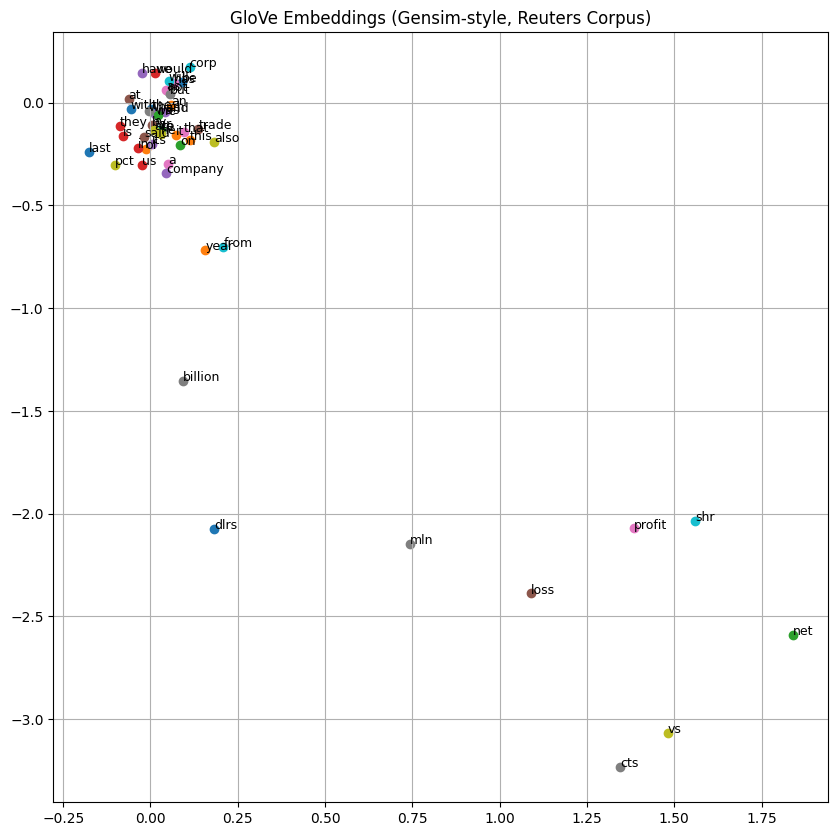

In [25]:
TOP_K = 50
word_counts = Counter([w for doc in corpus for w in doc])
top_words = [w for w, _ in word_counts.most_common(TOP_K) if w in word2index]

plt.figure(figsize=(10, 10))

for word in top_words:
    idx = word2index[word]
    x, y = embeddings[idx]
    plt.scatter(x, y)
    plt.text(x, y, word, fontsize=9)

plt.title("GloVe Embeddings (Gensim-style, Reuters Corpus)")
plt.grid(True)
plt.show()


In [29]:
np.save("emb_glove_g.npy", embeddings)
